# Using EcoFOCIpy to process raw field data

## Mooring / Timeseries Data

Basic workflow for each instrument grouping is *(initial archive level)*:
- Parse data from raw files into pandas dataframe
- output initial files (pandas->csv) **ERDDAP NRT** when no meta data is added

Convert to xarray dataframe for all following work *(working or final data level):
- TODO: Add metadata from instrument yaml files and/or header info
- ingest metadata from deployment/recovery records or cast logs
- process data beyond simple file translate
- apply any calibrations or corrections
    + field corrections
    + offsets
    + instrument compensations
    + some QC were available... this would be old-school simple bounds mostly
- adjust time bounds and sample frequency (xarray dataframe)
- save as CF netcdf via xarray: so many of the steps above are optional
    + **ERDDAP NRT** if no corrections, offsets or time bounds are applied but some meta data is
    + **Working and awaiting QC** has no ERDDAP representation and is a holding spot
    + **ERDDAP Final** fully calibrated, qc'd and populated with meta information

Plot for preview and QC
- preview images (indiv and/or collectively)
- manual qc process
- automated qc process ML/AI

Further refinenments for ERDDAP hosting:


## Example below is for SBE-37 but the workflow is similar for all instruments.

Future processing of this instrument can be a simplified (no markdown) process which can be archived so that the procedure can be traced or updated

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import yaml

import EcoFOCIpy.io.sbe_parser as sbe_parser #<- instrument specific
import EcoFOCIpy.io.ncCFsave as ncCFsave
import EcoFOCIpy.metaconfig.load_config as load_config

The sample_data_dir should be included in the github package but may not be included in the pip install of the package

## Simple Processing - first step

In [2]:
sample_data_dir = '/Users/bell/Programs/EcoFOCIpy/'
user_data_dir = '/Users/bell/ecoraid/2025/Moorings/25bs2a/'

In [3]:
###############################################################
# edit to point to {instrument sepcific} raw datafile 
datafile = user_data_dir+'raw/sbe37/25BS2A_sbe37_2024__55m.asc'
instrument = 'SBE-37 2024'
mooring_meta_file = user_data_dir+'logs/25BS-2A.yaml'
inst_meta_file = sample_data_dir+'staticdata/instr_metaconfig/sbe37_cf.yaml'
institution_meta_file = sample_data_dir+'staticdata/institutional_meta_example.yaml' #include uaf?
inst_shortname = 's37'
###############################################################

#init and load data
sbe37_wop = sbe_parser.sbe37()
(sbe37_wop_data,sbe37_wop_header) = sbe37_wop.parse(filename=datafile,
                                                    return_header=True,
                                                    datetime_index=True) 

The data is output as a pandas dataframe from the intial module call and if its available, a header

In [4]:
sbe37_wop_header

['* Sea-Bird SBE37 Data File:\n',
 '* FileName = C:\\data\\moorings\\2025\\dy2507_recovery\\BS2A(tall mooring)\\24-BS-2a_sbe37_2024__55m.asc\n',
 '* Software Version 1.59\n',
 '* Temperature SN = 2024\n',
 '* Conductivity SN = 2024\n',
 '* System UpLoad Time = Sep 02 2025 12:59:06\n',
 '** comp time=09/02/2025 19:56:00\n',
 '** ins tme= 09/02/2025 19:57:08\n',
 '** z=55m\n',
 '** \n',
 '** \n',
 '** \n',
 '** \n',
 '** \n',
 '* ds\n',
 '* SBE37-SM V 2.6b  SERIAL NO. 2024    02 Sep 2025  19:57:48\n',
 '* not logging: received stop command\n',
 '* sample interval = 3600 seconds\n',
 '* samplenumber = 3260, free = 229756\n',
 '* transmit real-time data\n',
 '* output salinity with each sample\n',
 '* do not output sound velocity with each sample\n',
 '* store time with each sample\n',
 '* number of samples to average = 4\n',
 '* reference pressure = 55.0 db\n',
 '* serial sync mode disabled\n',
 '* wait time after serial sync sampling = 30 seconds\n',
 '* internal pump not installed\n',
 

In [5]:
sbe37_wop_data

,temperature,conductivity,salinity
date_time,,,
2025-04-20 00:00:39,8.3752,0.00002,0.0041
2025-04-20 01:00:39,9.0236,0.00001,0.0045
2025-04-20 02:00:39,9.3404,0.00001,0.0047
2025-04-20 03:00:38,9.4122,0.00001,0.0048
2025-04-20 04:00:38,9.1492,0.00001,0.0046
...,...,...,...
2025-09-02 15:00:39,17.3292,0.06722,0.3877
2025-09-02 16:00:39,18.3913,0.06728,0.3785
2025-09-02 17:00:39,18.0126,0.06573,0.3728


## Time properties

Its unusual that our clocks drift to the point of concern for our instruments (if an instrument is off by 3 minutes but only sampling hourly... regridding that data will result in minimal changes).  However, there are a few time oriented modifications that may need to be made.

It is very easy to use pandas interplation and resample methods on the dataframe as is.  A few steps are suggested below:
- parse out on-deck (predeployment and recovery) data.  This can be done via pandas or xarray but requires the mooring metadata to have been read in.  See future steps below.
- even if the sample frequency is set to the desired measurement frequency, it would be good to perform a quick regridding as an assurance task
- FOCI data is usualy 1min, 10min, 1hr - and the 1min data is a fairly new (sbe56) data stream
    + subsampling high frequency data to lower frequency is easy via df.resample().mean()
    + you may want to take the median instead of the mean for noisy data (fluorometer) , occasionally decimating may be more appropriate if you want to downsize the dataset size but not smear features
    + shifting times can be a bit more involved.  There are two primary ways to do it, interpolate or shift
        - to interpolate, you will need to upsample your data to a higher frequency which will generate missing values, then interpolate (with a maximum gap size), then decimate.  This always has the artifact of smoothing data and decreasing the min/max values. **common on microcats and other 10min datasets**
        - shifting usually just involves droping extra time "digits", if you want hourly, you could just drop the trailing minutes assuming you are just off the hour (8:05 -> 8:00) or you can round to the nearest time unit but niether of these changes the data value, just the time associated with it. **common on seacats and other hourly datasets**
    + I suggest if no change is needed... resample().mean() to the sample frequency just in case there is a small deviation from expected (<1min)
    

In [6]:
sbe37_wop_data.index = sbe37_wop_data.index.round(freq='30T')
sbe37_wop_data

/var/folders/6r/n_mpcj7d7pdf9ncqvjy5vb8c0000jm/T/ipykernel_61054/130834644.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sbe37_wop_data.index = sbe37_wop_data.index.round(freq='30T')


,temperature,conductivity,salinity
date_time,,,
2025-04-20 00:00:00,8.3752,0.00002,0.0041
2025-04-20 01:00:00,9.0236,0.00001,0.0045
2025-04-20 02:00:00,9.3404,0.00001,0.0047
2025-04-20 03:00:00,9.4122,0.00001,0.0048
2025-04-20 04:00:00,9.1492,0.00001,0.0046
...,...,...,...
2025-09-02 15:00:00,17.3292,0.06722,0.3877
2025-09-02 16:00:00,18.3913,0.06728,0.3785
2025-09-02 17:00:00,18.0126,0.06573,0.3728


<Axes: xlabel='date_time'>

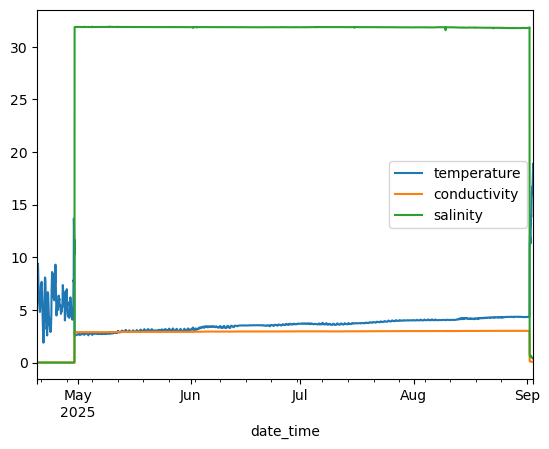

In [7]:
sbe37_wop_data.plot()

## Add Deployment meta information

Two methods are available (if comming from python2 world - ordereddict was important... in py38 a dictionary is inherently ordered)

In [8]:
#just a dictionary of dictionaries - simple
with open(mooring_meta_file) as file:
    mooring_config = yaml.full_load(file)

In [9]:
#just a dictionary of dictionaries - simple
with open(institution_meta_file) as file:
    institution_config = yaml.full_load(file)

## Calculate Salinity as it wasn't included in the sbe cnv file as it usually is

## Add Instrument meta information

Time, depth, lat, lon should be added regardless (always our coordinates) but for a mooring site its going to be a (1,1,1,t) dataset
The variables of interest should be read from the data file and matched to a key for naming.  That key is in the inst_config file seen below and should represent common conversion names in the raw data

In [10]:
with open(inst_meta_file) as file:
    inst_config = yaml.full_load(file)

In [11]:
# Add meta data and prelim processing based on meta data
# Convert to xarray and add meta information - save as CF netcdf file
# pass -> data, instmeta, depmeta
sbe37_wop_nc = ncCFsave.EcoFOCI_CFnc(df=sbe37_wop_data, 
                                instrument_yaml=inst_config, 
                                operation_yaml=mooring_config,
                                operation_type='mooring', 
                                instrument_id=instrument, 
                                inst_shortname=inst_shortname)
sbe37_wop_nc

At this point, you could save your file with the `.xarray2netcdf_save()` method and have a functioning dataset.... but it would be very simple with no additional qc, meta-data, or tuned parameters for optimizing software like ferret or erddap.

In [12]:
# expand the dimensions and coordinate variables
# renames them appropriatley and prepares them for meta-filled values
sbe37_wop_nc.expand_dimensions()

In [13]:
sbe37_wop_nc.variable_meta_data(variable_keys=list(sbe37_wop_data.columns.values),drop_missing=True)
sbe37_wop_nc.temporal_geospatioal_meta_data(depth='actual')
#adding dimension meta needs to come after updating the dimension values... BUG?
sbe37_wop_nc.dimension_meta_data(variable_keys=['depth','latitude','longitude'])

The following steps can happen in just about any order and are all meta-data driven.  Therefore, they are not required to have a functioning dataset, but they are required to have a well described dataset

In [14]:
#add global attributes
sbe37_wop_nc.deployment_meta_add()
sbe37_wop_nc.get_xdf()

#add instituitonal global attributes
sbe37_wop_nc.institution_meta_add(institution_yaml=institution_config)

#add instrument global attributes
sbe37_wop_nc.instrument_meta_data()

#add creation date/time - provenance data
sbe37_wop_nc.provinance_meta_add()

#provide intial qc status field
sbe37_wop_nc.qc_status(qc_status='unknown')

## Save CF Netcdf files

Currently stick to netcdf3 classic... but migrating to netcdf4 (default) may be no problems for most modern purposes.  Its easy enough to pass the `format` kwargs through to the netcdf api of xarray.

In [15]:
# combine trim (not mandatory) and filename together (saves to test.nc without name)

depth = str(int(mooring_config['Instrumentation'][instrument]['ActualDepth'])).zfill(4)
# mooring_yaml['Instrumentation'][self.instrument_id]['DesignedDepth'])).zfill(4) #<-- alternative
filename = "".join(mooring_config['MooringID'].split('-')).lower()+'_'+inst_shortname+'_'+depth+'m.nc'
sbe37_wop_nc.xarray2netcdf_save(xdf = sbe37_wop_nc.autotrim_time(),
                           filename=filename,format="NETCDF3_CLASSIC")

# don't trim the data and pass your own filename
# sbe37_wop_nc.xarray2netcdf_save(xdf = sbe37_wop_nc.get_xdf(),
#                            filename=filename,format="NETCDF4_CLASSIC")

In [16]:
sbe37_wop_nc.autotrim_time()

<xarray.Dataset> Size: 94kB
Dimensions:       (time: 2946, depth: 1, latitude: 1, longitude: 1)
Coordinates:
  * time          (time) datetime64[ns] 24kB 2025-04-30T05:00:00 ... 2025-08-...
  * latitude      (latitude) float64 8B 56.87
  * longitude     (longitude) float64 8B -164.1
  * depth         (depth) float64 8B 53.0
Data variables:
    temperature   (time, depth, latitude, longitude) float64 24kB 2.667 ... 4...
    conductivity  (time, depth, latitude, longitude) float64 24kB 2.885 ... 3...
    salinity      (time, depth, latitude, longitude) float64 24kB 31.88 ... 31.8
Attributes: (12/33)
    Latitude_DegMMddW:                      56 51.9944 N
    Longitude_DegMMddN:                     164 03.6818 W
    MooringID:                              25BS-2A
    platform_deployment_date:               2025-04-30T04:07:54Z
    platform_deployment_cruise_name:        DY2504
    platform_recovery_date:                 2025-08-30T22:40:00Z
    ...                                     ...
    InstrumentSerialNumber:                 2024
    InstrumentType:                         SBE-37
    date_created:                           2025-09-08T12:05:44Z
    date_modified:                          
    QC_indicator:                           unknown
    history:                                Trimmed to deployment.\nTrimmed t...

In [17]:
try:
    print(sbe37_wop_nc.autotrim_time().pressure.mean())
except:
    print(f'likely no pressure variable in datafile')

likely no pressure variable in datafile


<Figure size 640x480 with 0 Axes>

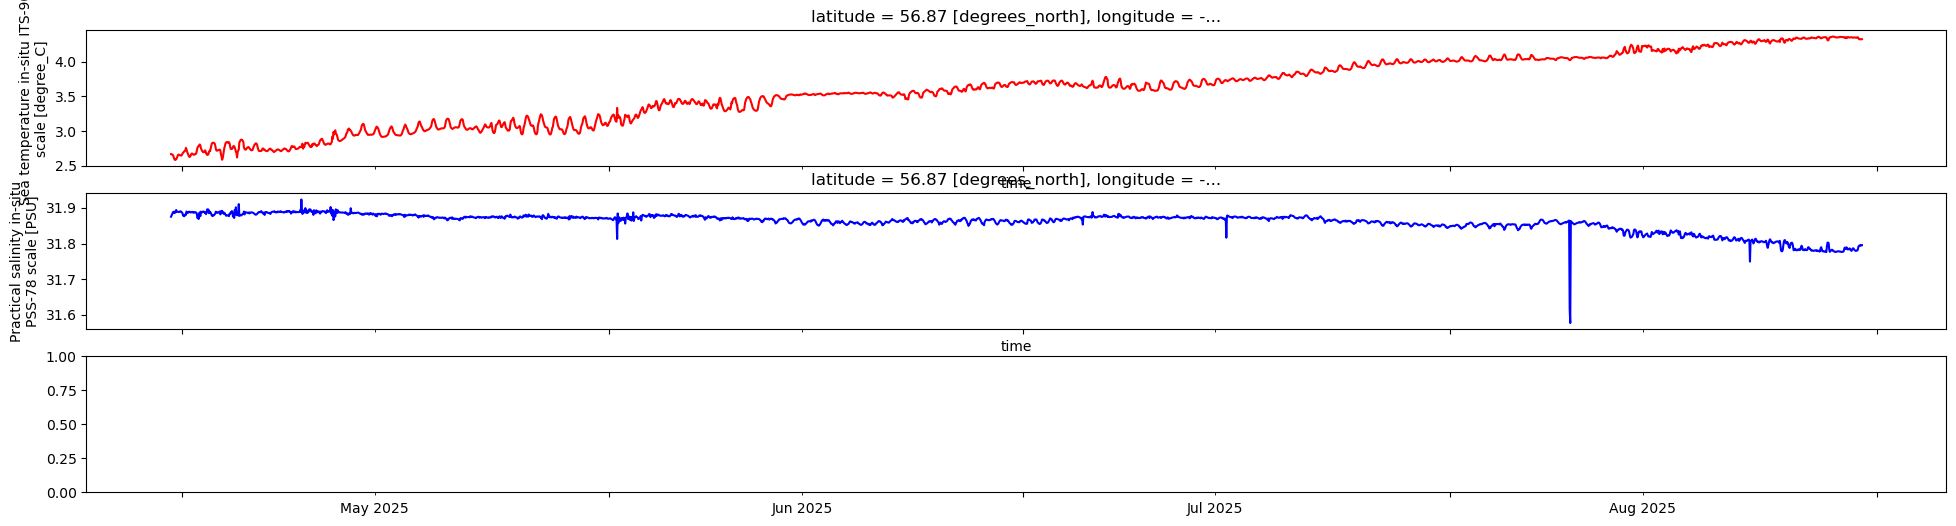

In [18]:
#wrap the plot in image settings for visual appeal
# may be able to make this cleaner or just a preset
%run '../../../settings/mpl_plot_settings.py'

%matplotlib inline
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker


fig, ax = plt.subplots(3,figsize=(24, 6),sharex=True)
sbe37_wop_nc.autotrim_time().temperature.plot(ax=ax[0],color='r')
sbe37_wop_nc.autotrim_time().salinity.plot(ax=ax[1],color='b')
try:
    sbe37_wop_nc.autotrim_time().pressure.plot(ax=ax[2],color='k')
except:
    pass

# xfmt = mdates.DateFormatter('%d-%b')
ax[2].xaxis.set_major_locator(DayLocator(bymonthday=1))
ax[2].xaxis.set_minor_locator(DayLocator(bymonthday=15))
ax[2].xaxis.set_minor_formatter(DateFormatter('%b %Y'))
ax[2].xaxis.set_major_formatter(DateFormatter(''))
ax[2].xaxis.set_tick_params(which='major', pad=3)
ax[2].xaxis.set_tick_params(which='minor', pad=5)

In [19]:
#csvoutput if necessary - untrimmed for deck analysis
(sbe37_wop_nc.get_xdf().to_dataframe()).to_csv(filename.replace('nc','csv'))

## Next Steps

QC of data (plot parameters with other instruments)
- be sure to updated the qc_status and the history

**no pressure var - so assume pressure correction from other depths**

## QC plotting against CTDs (here or in a seperate ipynb)

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import EcoFOCIpy.io.erddap as erddap
import datetime

# erddap.test_erddap_connection(url=url) #basic test for connection to internal server, no response is a good thing

In [24]:
dep_details = {'url':"http://ecofoci-field.pmel.noaa.gov:8082/erddap",
               'cruiseid':'dy2504',
               'qclevel':'preliminary',
               'concastno':'022'
              }

rec_details = {'url':"http://ecofoci-field.pmel.noaa.gov:8082/erddap",
               'cruiseid':'skq202515s',
               'qclevel':'preliminary',
               'concastno':'009'
              }
               
depcast = erddap.erddapCTDretrieve(**dep_details)
# reccast = erddap.erddapCTDretrieve(**rec_details)

some variable names switch between preliminary and final... this will eventually be resolved

In [25]:
depcast.columns = [x.split()[0] for x in depcast.columns]
# reccast.columns = [x.split()[0] for x in reccast.columns]

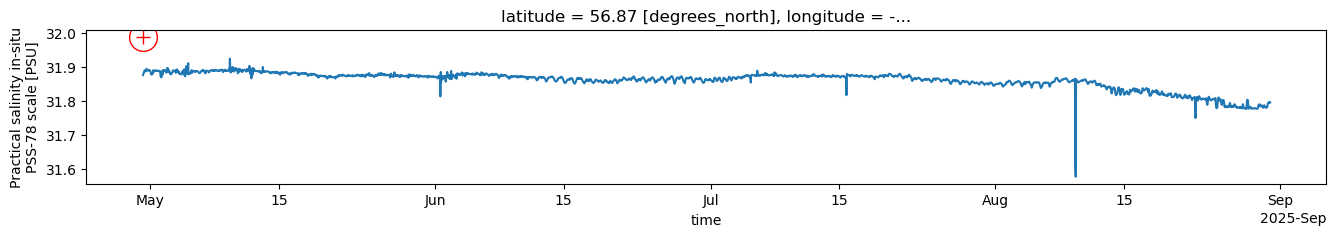

In [26]:
#plot ctd values with a small circular radius and zoom in on near their equivalent mooring time span, we are looking for visual discrepencies
#cycle through each depth and plot respective plot
depth = int(mooring_config['Instrumentation'][instrument]['ActualDepth'])

fig, ax = plt.subplots(1,figsize=(16, 2))
sbe37_wop_nc.autotrim_time().salinity.plot(x="time",hue="depth",ax=ax, add_legend=False);
# ax.plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time']),
#         reccast[reccast['pressure'] == depth]['S_41'],
#         'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
# ax.plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time']),
#         reccast[reccast['pressure'] == depth]['S_41'],
#         '+',markersize=10,markerfacecolor='none',markeredgecolor='red')
ax.plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['S_41'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax.plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['S_41'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')

fig.savefig(f"images/{filename.replace('nc','_salCal.png')}")

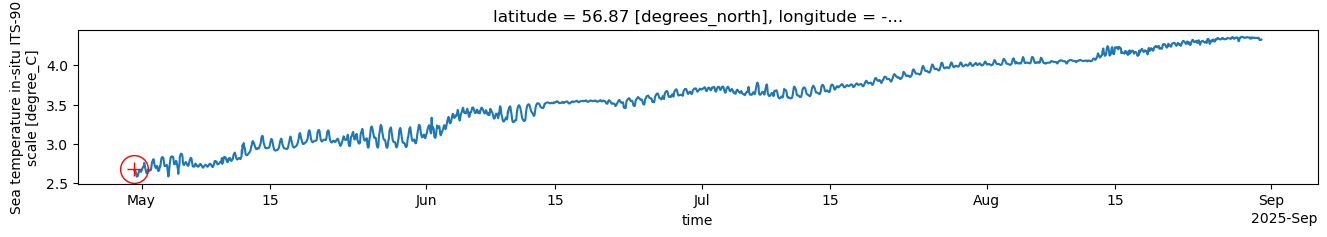

In [27]:
#plot ctd values with a small circular radius and zoom in on near their equivalent mooring time span, we are looking for visual discrepencies
#cycle through each depth and plot respective plot
# depth = int(mooring_config['Instrumentation'][instrument]['ActualDepth'])

fig, ax = plt.subplots(1,figsize=(16, 2))
sbe37_wop_nc.autotrim_time().temperature.plot(x="time",hue="depth",ax=ax, add_legend=False);
# ax.plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time']),
#         reccast[reccast['pressure'] == depth]['T_28'],
#         'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
# ax.plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time']),
#         reccast[reccast['pressure'] == depth]['T_28'],
#         '+',markersize=10,markerfacecolor='none',markeredgecolor='red')
ax.plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['T_28'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax.plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['T_28'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')

fig.savefig(f"images/{filename.replace('nc','_tempCal.png')}")

In [28]:
#print collocated cast comparison
mooring = sbe37_wop_nc.autotrim_time().sel(time=datetime.datetime.strptime(depcast['time'].unique()[0],
                                                                 '%Y-%m-%dT%H:%M:%SZ'),
                                 method='nearest')
print('Deployment')
print('T0:',mooring.temperature.values[0][0],depcast[depcast['pressure'] == depth]['T_28'].values)
print('T1:',mooring.temperature.values[0][0],depcast[depcast['pressure'] == depth]['T2_35'].values)
print('S0:',mooring.salinity.values[0][0],depcast[depcast['pressure'] == depth]['S_41'].values)
print('S1:',mooring.salinity.values[0][0],depcast[depcast['pressure'] == depth]['S_42'].values)

# mooring = sbe37_wop_nc.autotrim_time().sel(time=datetime.datetime.strptime(reccast['time'].unique()[0],
#                                                                  '%Y-%m-%dT%H:%M:%SZ'),
#                                  method='nearest')
# print('Recovery')
# print('T0:',mooring.temperature.values[0][0],reccast[reccast['pressure'] == depth]['T_28'].values)
# print('T1:',mooring.temperature.values[0][0],reccast[reccast['pressure'] == depth]['T2_35'].values)
# print('S0:',mooring.salinity.values[0][0],reccast[reccast['pressure'] == depth]['S_41'].values)
# print('S1:',mooring.salinity.values[0][0],reccast[reccast['pressure'] == depth]['S_42'].values)


Deployment
T0: [2.6675] [2.6754]
T1: [2.6675] [2.6755]
S0: [31.8752] [31.9878]
S1: [31.8752] [31.9868]
